# Sentiment Analysis of Steam Reviews

The video game store, [Steam](https://store.steampowered.com/), contains a large amount of user submitted reviews for their various games along with a positive or negative score. In this project, we want to apply machine learning to see if we can predict the score based on the review text. If successful, we could then apply this to areas where we don't know if the text has a positive or negative sentiment. For example, classifying posts on a forum, such as [Reddit](https://www.reddit.com/).

In [1]:
import datasets
import datasets.utils.logging
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

## Hyperparameters

First we start by setting the hyperparameters, which have all be set via grid search. The first is the number of epochs to train for before stopping. The second is the batch size, which defines how many batches of reviews we will send to the train function. The third is the max tokens, which defines them maxium number of tokens we will send per batch. Finally, the last defines the filter size of the two convolutional layers.

In [2]:
# Hyperparameters
epochs = 12
batch_size = 1024
max_tokens = 512
filter_size = [3, 7]

## Setup

Here we set the random number generators to a fixed seed, so we will be able to reproduce our results. We also select either the CPU or GPU to use for training our model. Ideally we use the GPU, which is significantly faster.

In [3]:
# Set the random seed for deterministic behaviour
seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
# Select GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

Now, we're going to set up the dataset. The first thing we're going to do is create smaller version of the Steam reviews dataset. For this we're going to randomly sample 10,000 rows out of 6.4 million rows.

In [5]:
# Define a function to create a partial dataset
def create_partial_dataset(nrows=1000, override=True):
    
    dataset_path = 'data/dataset_' + str(nrows) + '.csv'
    if (os.path.exists(dataset_path) and not override):
        return dataset_path
    
    # Load the full dataset
    # Location: https://www.kaggle.com/datasets/andrewmvd/steam-reviews
    df = pd.read_csv('data/dataset.csv')
    print(df.shape)

    # Make a partial dataset for exploration composed 
    # of 50% positive and 50% negative reviews.
    df = df.groupby('review_score').sample(n=int(nrows/2), random_state=14).sort_index()

    # Export to CSV
    df.to_csv(dataset_path)

    return dataset_path

# Disable dataset progress bars
datasets.utils.logging.disable_progress_bar()

# Create a partial dataset for exploration
dataset_nrows = 10000
dataset_path = create_partial_dataset(dataset_nrows, override=False)

# Load the Steam reviews dataset
full_data = datasets.load_dataset('csv', data_files=dataset_path, split='all')

Next, we're going to apply preprocessing fixes to ensure the data can be processed correctly. All instances with missing review text were removed, all text was changed to lowercase, multiple contiguous spaces were removed, and the negative labels were changed from -1 to 0.

In [6]:
# Define a function to apply preprocessing fixes to the text
def preprocessing_text(row):

    # Make the text lower case
    # Remove multiple space chars
    row['text'] = row['text'].lower()
    row['text'] = ' '.join(row['text'].split()).strip()
    return row

# Define a function to apply preprocessing fixes to the labels
def preprocessing_labels(row):

    # Alter the -1 (negative) label to be 0
    if (row['label'] == -1):
        row['label'] = 0
    return row

# Remove unnecessary columns
full_data = full_data.remove_columns(['Unnamed: 0', 'app_id', 'app_name', 'review_votes'])

# Rename the columns to be generic
full_data = full_data.rename_column('review_text', 'text')
full_data = full_data.rename_column('review_score', 'label')

# Remove entries that contain no text
full_data = full_data.filter(lambda row: row['text'] is not None)

# Apply preprocessing fixes to the data
full_data = full_data.map(preprocessing_text)
full_data = full_data.map(preprocessing_labels)

Next, we're going to turn the review text, essentially we're going to splt it into words. After that we're going to create mapping of words to integer values and then turn our string tokens into integer tokens (i.e., numericalise them). You can see a few examples below the code block.

In [7]:
# Define the function that will split the sentences into tokens
def tokenize(row, max_tokens):
    tokenizer = get_tokenizer('basic_english')
    tokens = tokenizer(row['text'])[:max_tokens]
    return {'tokens': tokens}

# Split the text into tokens
full_data = full_data.map(
    tokenize, fn_kwargs={'max_tokens': max_tokens}
)

# Define a mapping of string tokens to integer values
vocab = build_vocab_from_iterator(
    full_data['tokens'],
    min_freq=5,
    specials=['<unk>', '<pad>'],
)
vocab.set_default_index(vocab['<unk>'])

# Store the index of the padding token
pad_index = vocab['<pad>']

# Define the function that replaces string tokens with integer values
def numericalise(row, vocab):
    tokens = vocab.lookup_indices(row['tokens'])
    return {'tokens': tokens}

# Replace the string tokens with integer values
full_data = full_data.map(numericalise, fn_kwargs={'vocab': vocab})
full_data = full_data.with_format(type='torch', columns=['tokens', 'label'])

# Example tokens
vocab(['video', 'game', 'good', 'bad'])

[514, 10, 49, 106]

Here, we're going to define a function that can be used to batch our tokens and labels (i.e., the positive or negative classification).

In [8]:
# Define the the function for collating and batching the data
def collate_fn(pad_index):
    def collate_fn(batch):
        batch_tokens = [i['tokens'] for i in batch]
        batch_tokens = nn.utils.rnn.pad_sequence(
            batch_tokens, padding_value=pad_index, batch_first=True
        )
        batch_label = [i['label'] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {'tokens': batch_tokens, 'label': batch_label}
        return batch

    return collate_fn



At this point we're going to finally split our dataset into training, validation, and test datasets. The data is split 60% training, 20% validation, and 20% test, which for 10,000 rows is 6,000 training, 2,000 validation, and 2,000 test. We also create DataLoaders that will be passed to our train and evaluate functions in the CNN's model, which will supply the data in the correct batches. 

In [9]:
# Split the dataset into training/validation and test sets
full_data = full_data.train_test_split(test_size=0.2)
train_valid_data = full_data['train']
test_data = full_data['test']

# Further split the training set into training and validation sets
train_valid_data = train_valid_data.train_test_split(test_size=0.25)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

# Calculate the number of unique labels
unique_labels = len(train_data.unique('label'))

# Create the data loaders for training section
train_data_loader = DataLoader(train_data, batch_size, collate_fn=collate_fn(pad_index), shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size, collate_fn=collate_fn(pad_index))
test_data_loader = DataLoader(test_data, batch_size, collate_fn=collate_fn(pad_index))

## Convolutional Neural Network (CNN)

Here we define the class for our [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) model. CNNs, are type of unidirectional neural network that is composed of layers of neurons connected together via weighted paths. However, unlike fully connected networks, the use of filters means that every neuron in a layer is not connected to every other neuron in the prior layer. Instead it is only dependent on the neurons nearby with the number of neurons depending on the filter size, which substantially reduces the number of parameters.

It is composed of 5 primary functions.

__\_\_init\_\___: Defines the shape of the neural network. It is composed of an embedding layer, two convolutional layers, two max pooling layers (directly defined in the forward function), and a fully connected layer.

__forward__: Passes the data through the neural network and produce the predicted labels based on the batches of tokens supplied.

__train__: Handles the processing of training the model. It loops through the batches of the training data and feeds them into the model where the predicted labels are returned. In each loop, it calculates the loss metrics, which in our case is [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy), performs [backpropagation](https://en.wikipedia.org/wiki/Backpropagation), and the optimiser step.

__evaluate__: Handles evaluating the performance of the model. It loops through batches of the validation or testing data and feeds them into the model where the predicted labels are returned. These predictions are then checked against the true labels and the loss and accuracy are computed.

__predict__: Calculates the predict label and the probability of it being that label for any supplied review text.

In [10]:
# Define the convolutional neural network
class CNN(nn.Module):

    # Define the function for initliasing the CNN model
    def __init__(
        self,
        embedding_dim, # The size of each embedding vector
        filters, # Number of filters
        filter_size, # The size of the filters
        max_tokens, # Max tokens
        num_embeddings, # Size of the dictionary of embeddings
        output_dim, # No. of unique labels
        pad_index, # The index of the pad, which will get defaulted to all zeros
        device # Run on the CPU or GPU
    ):
        super().__init__()
     
        # Store for later use
        self.vocab = vocab
        self.device = device
     
        # Lookup table that stores embeddings
        num_embeddings = len(vocab)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=pad_index)
        
        # Convolution layers
        # Embedding vector size, Number of filters, Filter/Kernel size
        self.conv1 = nn.Conv1d(embedding_dim, filters, filter_size[0], padding='same')
        self.conv2 = nn.Conv1d(embedding_dim, filters, filter_size[1], padding='same')

        # Linear layer
        # No. of convolution layers * Earlier output channels, No. of unique labels
        self.fc1 = nn.Linear(2 * filters, output_dim)

        # Define the loss function and optimiser
        # Cross-entropy loss and Adaptive Moment Estimation
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = optim.Adam(self.parameters())
    
    # Define the function to return the total model parameters
    def total_parameters(self):
    
        # Compute the total number of parameters
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    # Define the function to process a pass through the CNN
    def forward(self, tokens):

        # Tokens
        # Size: [Batch size, Max tokens]
        # Example: [512, 256]

        # Token embeddings
        # Size: [Batch size, Max tokens, Embedding vector size]
        # Example: [512, 256, 300]
        embedded = self.embedding(tokens)

        # Re-arrange the token embeddings
        # Size: [Batch size, Embedding vector size, Max tokens]
        # Example: [512, 300, 256]
        embedded = embedded.permute(0, 2, 1)

        # First convolutional layer plus ReLU activation
        # Size: [Batch size, Output channels, Max tokens - Filter size + 1]
        # Example: [512, 100, 254]
        conved1 = torch.relu(self.conv1(embedded))

        # Second convolutional layer plus ReLU activation
        # Size: [Batch size, Output channels, Max tokens - Filter size + 1]
        # Example: [512, 100, 254]
        conved2 = torch.relu(self.conv2(embedded))    

        # First max pool layer
        # Size: [Batch size, Output channels]
        # Example: [512, 100]
        pooled1 = conved1.max(dim=-1).values

        # Second max pool layer
        # Size: [Batch size, Output channels]
        # Example: [512, 100]
        pooled2 = conved1.max(dim=-1).values
        
        # Concatenate the tensors returned by the pooled layers
        # Size: [Batch size, 2*Output channels]
        # Example: [512, 200]
        cat = torch.cat([pooled1, pooled2], dim=-1)

        # Linear layer
        # Size: [Batch size, No. of unique labels]
        # Example: [512, 2]
        prediction = self.fc1(cat)      
        return prediction

    # Define the function to train the model
    def train(self, train_loader):
    
        # Loop through every batch in the training data
        running_loss = 0.0
        running_accuracy = 0.0
        for batch in train_loader:
    
            # Send the data to the GPU
            tokens, labels = batch['tokens'].to(self.device), batch['label'].to(self.device)
    
            # Zero the parameter gradients
            self.optimizer.zero_grad()
    
            # Forward + backward + optimize
            predictions = self(tokens)
            loss = self.criterion(predictions, labels)
            loss.backward()
            self.optimizer.step()
    
            # Calculate the running loss and accuracy
            running_loss += loss.item()
            running_accuracy += get_accuracy(predictions, labels).item()
            
        return (running_loss / len(train_loader), 
               running_accuracy / len(train_loader))

    # Define the function to evaluate the model
    def evaluate(self, test_loader):
    
        # Loop through every batch in the test data
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for batch in test_loader:
    
                # Send the data to the GPU
                tokens, labels = batch['tokens'].to(self.device), batch['label'].to(self.device)
    
                # Evaluate the predicted label
                predictions = self(tokens)
                loss = self.criterion(predictions, labels)
        
                # Calculate the running loss and accuracy
                running_loss += loss.item()
                running_accuracy += get_accuracy(predictions, labels).item()
    
        return (running_loss / len(test_loader), 
               running_accuracy / len(test_loader))

    # Define the function to produce a prediction
    def predict(self, text):
    
        # Form the text like a data row
        text = {'text': text}
    
        # Apply preprocessing, tokenize, and numericalise the text
        text = preprocessing_text(text)
        tokens = tokenize(text, max_tokens)['tokens']
        ids = self.vocab.lookup_indices(tokens)
        
        # Create the tensor
        tensor = torch.tensor(ids, dtype=torch.int64, device=self.device).unsqueeze(dim=0)
    
        # Get the prediction from the model
        prediction = self(tensor).squeeze(dim=0)
        predicted_class = prediction.argmax(dim=-1).item()
    
        # Get the probability of the classification
        probabilities = torch.softmax(prediction, dim=-1)
        predicted_probability = probabilities[predicted_class].item()
        return(predicted_class, predicted_probability)

A helper function that initiliases the model and sets the embedding weights with pretrained weights from [GloVe](https://nlp.stanford.edu/projects/glove/).

In [11]:
# Define a function to initialise a model
def create_cnn_model(filter_size, max_tokens, vocab, unique_labels, pad_index, device):

    # Note: The embedding vector size has to remain at 300 in order to match 
    # that returned by GloVe. It can be changed if the usage of GloVe is removed.
    
    # Model inputs
    embedding_dim = 300
    filters = 100

    # Initialise the model
    model = CNN(
        embedding_dim, # The size of each embedding vector
        filters, # Number of filters  
        filter_size, # The size of the filters
        max_tokens, # Max tokens
        vocab, # Size of the dictionary of embeddings
        unique_labels, # No. of unique labels
        pad_index, # The index of the pad, which will get defaulted to all zeros
        device # Run on the CPU or GPU
    )
    
    # Use starting weights from GloVe
    # https://nlp.stanford.edu/projects/glove/
    vectors = torchtext.vocab.GloVe(dim=embedding_dim)
    model.embedding.weight.data = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    # Move the model to the GPU
    model = model.to(device)

    return model

In [12]:
# Define a function to compute the accuracy of the predictions
def get_accuracy(prediction, label):
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / len(prediction)
    return accuracy

## Training

This is the primary training loop for the program. It will perform a loop depending on the number of required epochs. For each epoch, it will train the model over the entire dataset, evaluate its performance, and then store the performance metrics for later review. It will also store the model weightings for the best epoch measured against the cross entropy loss on the validation set.

In [13]:
# Results storage
best_epoch = 0
best_valid_loss = float('inf')
results = {
    'Epoch': [], 
    'Training (Loss)': [], 'Training (Accuracy)': [], 
    'Validation (Loss)': [], 'Validation (Accuracy)': []
}

# Create the model
model = create_cnn_model(filter_size, max_tokens, vocab, unique_labels, pad_index, device)

# Run the required number of epochs
start = time.time()
print('Epoch: ', end='')
for epoch in range(1, epochs+1):

    # Run the model
    print(epoch, end=' ')
    train_loss, train_acc = model.train(train_data_loader)
    valid_loss, valid_acc = model.evaluate(valid_data_loader)

    # Store the results of the run
    results['Epoch'].append(epoch)
    results['Training (Loss)'].append(train_loss)
    results['Training (Accuracy)'].append(train_acc)
    results['Validation (Loss)'].append(valid_loss)
    results['Validation (Accuracy)'].append(valid_acc)

    # Save the best set of weightings
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'checkpoints/cnn_final.pt')
        best_valid_loss = valid_loss
        best_epoch = epoch

# Print the training time
end = time.time()
print('| Validation (Loss):', str(np.round(best_valid_loss, 6)), end=' ')
print('| Training Time:', str(np.round(end-start, 2))+'s')

Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 | Validation (Loss): 0.413981 | Training Time: 29.43s


## Results

Once we're finished training the model, we can see our results and how they have changed with each epoch. If the data, model, and hyperparameters have remained unchanged. then we should see that the best epoch was 12 with a validation loss of only 0.413981.

In [14]:
# Convert to data frame and then output the results
results_df = pd.DataFrame(results)
results_df.to_csv('results/final_results.csv', index=False)
results_df.style.hide()

Epoch,Training (Loss),Training (Accuracy),Validation (Loss),Validation (Accuracy)
1,0.667029,0.597821,0.631645,0.652273
2,0.600010,0.698303,0.579495,0.686253
3,0.537166,0.738182,0.522695,0.727582
4,0.478205,0.760692,0.486385,0.747202
5,0.435477,0.779018,0.463346,0.757731
6,0.401504,0.801007,0.443551,0.766771
7,0.373551,0.815573,0.437441,0.761838
8,0.346834,0.826910,0.435137,0.780356
9,0.324945,0.837878,0.421277,0.781458
10,0.301875,0.850175,0.420348,0.772831


We can also view the same results in chart form.

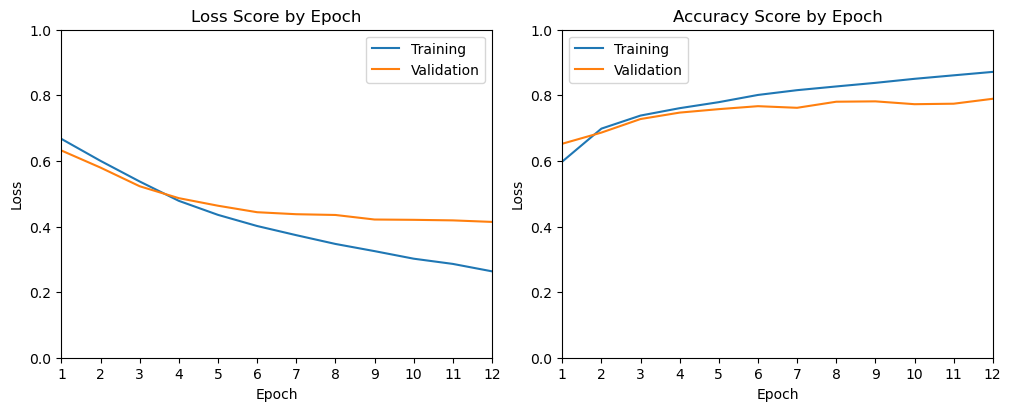

In [15]:
# Define the chart layout
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 1*4), layout='constrained')

# Draw the loss chart
ax = axs[0]
ax.plot(results_df['Epoch'], results_df['Training (Loss)'], label='Training')
ax.plot(results_df['Epoch'], results_df['Validation (Loss)'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim(1, np.max(results_df['Epoch']))
ax.set_ylim(0, 1)
ax.set_xticks(results_df['Epoch'])
ax.set_title('Loss Score by Epoch')
ax.legend()

# Draw the accuracy chart
ax = axs[1]
ax.plot(results_df['Epoch'], results_df['Training (Accuracy)'], label='Training')
ax.plot(results_df['Epoch'], results_df['Validation (Accuracy)'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim(1, np.max(results_df['Epoch']))
ax.set_ylim(0, 1)
ax.set_xticks(results_df['Epoch'])
ax.set_title('Accuracy Score by Epoch')
ax.legend()

plt.show()

Now that we have the best version of the model, we load the weightings from the selected epoch calculate our loss and accuracy against the testing dataset. In the end, we managed 0.7924 or 79.24% accuracy, which seems reasonable for 10,000 rows.

In [16]:
# Load the best set of weighting
model.load_state_dict(torch.load('checkpoints/cnn_final.pt'))

# Display the metrics on the testing set
test_loss, test_acc = model.evaluate(test_data_loader)
final_results_df = results_df.sort_values('Validation (Loss)').head(1)
final_results_df['Testing (Loss)'] = np.round(test_loss, 6)
final_results_df['Testing (Accuracy):'] = np.round(test_acc, 6)
final_results_df.style.hide()

Epoch,Training (Loss),Training (Accuracy),Validation (Loss),Validation (Accuracy),Testing (Loss),Testing (Accuracy):
12,0.263356,0.871315,0.413981,0.789345,0.430199,0.792425


## Predictions

Finally, now we have our trained model, we can use it perform predictions on sample Steam reviews. Here we can see a sample positive and negative review being correctly classified by the model. The model could now be applied to video game feedback that lacks a clear classification, such as forum posts.

In [17]:
# Positive review sample
review_text = 'Shogun 2 might represent the absolute peak of modern Total War. Highly recommended.'
prediction = model.predict(review_text)
print('Review:', review_text, '\nPrediction:', 'Positive' if prediction[0]==1 else 'Negative', '| Probability:', np.round(prediction[1], 4))

Review: Shogun 2 might represent the absolute peak of modern Total War. Highly recommended. 
Prediction: Positive | Probability: 0.9617


In [18]:
# Negative review sample
review_text = 'Rome wasn\'t patched in a day.'
prediction = model.predict(review_text)
print('Review:', review_text, '\nPrediction:', 'Positive' if prediction[0]==1 else 'Negative', '| Probability:', np.round(prediction[1], 4))

Review: Rome wasn't patched in a day. 
Prediction: Negative | Probability: 0.9846
